# Credit Card Default Prediction Project

Based on the dataset UCI Machine Learning Repository

The original paper that works with this dataset is : Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

* __[Link to original paper](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf)__

* __[Link to UCI dataset page](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__

### Dataset Description
* Data consists of 30 000 points and 23 features and 1 label


### Project Outline
Data preparation and exploration -> ML models hyperparameters tuning -> Combination into a final model

## Import : Data and Libraries
### Library Imports

In [1]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Optimizer
from hyperopt import Trials, fmin, tpe

from evalmodel_helper import fitModel, evalMetrics


# Model hyperparameter space to be optimized
from models_spaces import xgb_fitting_setting, xgb_space, ada_loss_functions, ada_space,\
    gbrt_loss_functions, gbrt_space, log_space, svm_space, svm_kernels, svm_kernel_degrees,\
    INT_KEYS

# Model objective function builder
from hyperopt_objective import build_objective_func

sns.set_style("dark")
sns.set_context("paper")



### Import and pre-processing of dataset 
(preprocessing : transforming data into ML model readable format)

#### Data Importing

In [2]:
# load data internally
_df_train = pd.read_csv("DataFiles/CreditCard_train.csv", index_col=0, header=1)
_df_test = pd.read_csv("DataFiles/CreditCard_test.csv", index_col=0, header=1)

# create external df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()


#### Train data head and description

In [3]:
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df_train.describe()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,-0.252917,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,1.136993,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


### Pandas DataFrame processing

In [5]:
# renaming columns for consistency and simplicity
df_train = df_train.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
df_test = df_test.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

label = df_train.columns[-1] # = `DEFAULT`
features = list(df_train.columns)[:-1]

y_train = df_train[label]
X_train = df_train[features]

y_test = df_test[label]
X_test = df_test[features]


__Comment__ : All the data types are integers and thus workable for ML models. There are no null values (arbitrarily checked and all features have the same count). Values in the `SEX`, `EDUCATION` are have a specified range, however, some values are not contained. <br>
Optional to look at data further in `data_exploration.ipynb`.


## Data Pipeline
* includes scaling, sampling and (future work : feature transformation)

We take the training:validation:test ratios as 60:20:20.
We change X_train into a training set and validation set.

In [6]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)


Scaling the dataset for computational efficiency of ML models operations (fitting, prediction).

In [7]:
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# X_train_transformed, y_train_transformed = SMOTE(random_state=3).fit_resample(X=X_train, y=y_train)


### Benchmarking some standard ML models

Checking the ML models
* xgboost, adaboost, gradientboostingregressor, logistic regression and support vector machines


## Hyperparameter tuning of ML models

Saving data in a pickle file and opened again in model objectives. (not sure if I can include them as input to the objectives of each model, for version 2..)


Hyperparameter tuning framework consists of a tuner (hyperopt), optimization space (model dependent), and objective function (model  dependent)
These are imported.

### ML models to be optimized



### Tuning

For tuning we will be first split up the training data into a validation


Set variable `long_run=True` for a long run.


In [8]:
long_run = False

if long_run:
    max_evals = 40
    max_evals_slow = 40

if not long_run:
    max_evals = 6
    max_evals_slow = 3

In [9]:

models_list = [xgb.XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          LogisticRegression,
          SVC
]

# to be import
models_space_list = [xgb_space,
                ada_space,
                gbrt_space,
                log_space,
                svm_space
]

models_choices = [{},
                  {'loss' : ada_loss_functions},
                  {'loss' : gbrt_loss_functions},
                  {},
                  {'kernel' : svm_kernels, 'degree' : svm_kernel_degrees}]

# models_choices = {'XGBRegressor':None,
#                  'AdaBoostRegressor': ada_loss_functions,
#                  'GradientBoostingRegressor': gbrt_loss_functions,
#                  'LogisticRegression': None,
#                  'SVC': [svm_kernels, svm_kernel_degrees]} # if kernel is not poly, degree is ignored



In [10]:
def buildHyperoptTunedFittedModel(model, model_space, model_choices : dict, X_train : np.ndarray, y_train,
                                  tuning_measure : str, max_evals : int = 10, cross_val_method : int = 0,
                                  **fitting_setting):
    """

    :param model:
    :param model_space:
    :param model_choices:
    :param X_train:
    :param y_train:
    :param tuning_measure:
    :param max_evals:
    :param cross_val_method:
    :param fitting_setting:
    :return:
    """

    trials = Trials()

    tuning_objective = build_objective_func(model=model, X_train=X_train, y_train=y_train,
                                            tuning_measure=tuning_measure, cross_val_method=cross_val_method,
                                            **fitting_setting)

    print('Starting hyperparameter search : \n')
    model_best_hyperparams = fmin(fn = tuning_objective,
                            space = model_space,
                            algo = tpe.suggest,
                            max_evals = max_evals,
                            trials = trials)

    # fmin returns space in floats (for some reason changed the type int to float)
    for key in INT_KEYS:
        if key in model_best_hyperparams.keys():
            model_best_hyperparams[key] = int(model_best_hyperparams[key])

    # when model space is a choice, `model_best_hyperparams` gives the index of the selected choice
    # model options a dict with keys: as the option name and value as list of options
    for choice, choice_option in model_choices.items():
        model_best_hyperparams[choice] = choice_option[model_best_hyperparams[choice]]

    tuned_model = model(**model_best_hyperparams)

    return fitModel(tuned_model=tuned_model, X_fitting=X_train, y_fitting=y_train, eval_metrics=True, confusion_matrix=False)


Change `y_test` from `pd.Series` into `np.ndarray` for sorting

In [11]:
y_test = y_test.to_numpy()

## Performance at given percentages
### robustness

As opposed to simply classifiying clients as expected to default vs not-expected to default, quantifying is more meaningful. I.e. defining a probability of default has more potential.

To estimate the real probability, the Smooth Sorting Method can be used, which estimates the real probability by looking at neighboring points and taking the mean of these values.

__Smooth Sorting Method__ from the original paper (Yeh, I. C., & Lien, C. H. (2009)):

$$\text{P}_i = \frac{\sum_{j=-n}^{n}\text{Y}_{i-j}}{2n+1}$$

where $\text{P}_i$ is the estimated real probability of default, $\text{Y}_{i}$ is the binary variable of default (1) or non-default (0), $n$ is the number of data for smoothing.<br>
The Smooth Sorting Method is used on sorted data, from the lowest probability of default occuring to the highest probability of default occuring.

This is interesting to look at because loaners adopt different risk strategies.
( (?) for this we consider at 20% and 80% (?) )

In [12]:
def realProbabilitySSM(y_real : np.ndarray, y_predicted : np.ndarray, n : int, plot : bool = True):

    sorted_index = np.argsort(y_predicted)
    y_real_sorted = y_real[sorted_index]
    y_predicted_sorted = y_predicted[sorted_index]

    intermediate_real_probability = np.array([])
    for counter in range(n, len(y_real)-n):
        intermediate_real_probability = np.append(intermediate_real_probability,
                                                  np.mean(y_real_sorted[counter-n:counter+n]))

    r2 = r2_score(y_real, y_predicted)

    if plot:
        y_predicted_selected = y_predicted_sorted[n:len(y_real)-n]
        plt.plot(y_predicted_selected,intermediate_real_probability)
        plt.grid(True)
        plt.xlim([0,1])
        plt.xlabel('Predicted probability')
        plt.ylabel('Real probability using SSM')
        plt.annotate(f'$R^2 = {r2}$', (0.05, 0.95))
        plt.grid(True, which='both')
        plt.show()

    print(f'r2 score : {r2}\n')
    return r2


Starting hyperparameter search : 

SCORE:                                                
0.6421881392961084                                    
SCORE:                                                                           
0.6047499942101485                                                               
SCORE:                                                                           
0.636449431436578                                                                
SCORE:                                                                           
0.611668866810255                                                                
SCORE:                                                                           
0.629800751908721                                                                
SCORE:                                                                           
0.6368788454264033                                                               
SCORE:                             

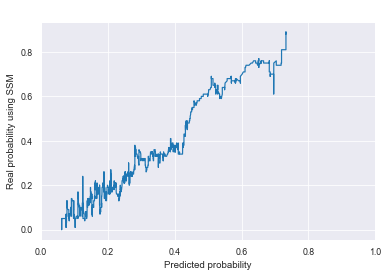

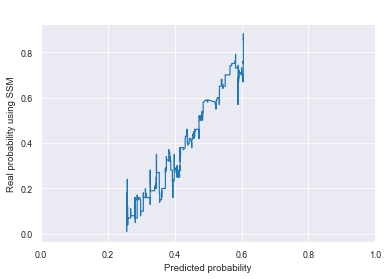

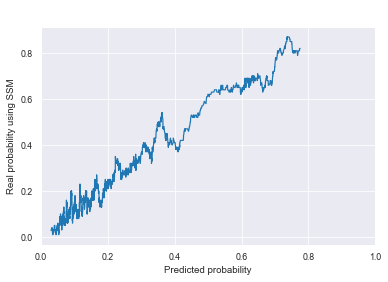

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


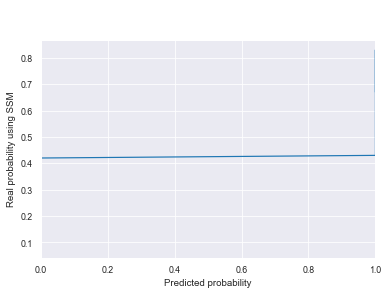

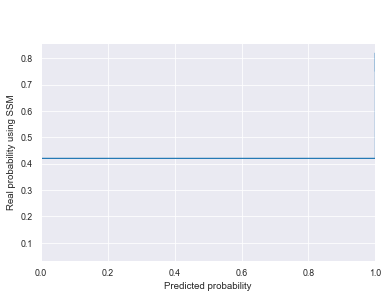

In [13]:

fitted_models_list = []
accuracy_scores = []
r2_scores = []
n = 50
max_evals = 40
cross_val_method = 0

for model, model_space, model_choices in zip(models_list, models_space_list, models_choices):
    fitted_model = buildHyperoptTunedFittedModel(model=model, model_space=model_space, model_choices=model_choices, X_train=X_train,
                                                 y_train=y_train, tuning_measure='roc', max_evals=max_evals,
                                                 cross_val_method=cross_val_method)
    y_pred = fitted_model.predict(X_test)

    print(f'Performance on test data of model {model} \n')
    accuracy_scores.append(evalMetrics(y_test, y_pred>0.5, confusion_matrix=False))
    r2_scores.append(realProbabilitySSM(y_test,y_pred, n=n, plot=True))


The search selects the best considered (not the best in the space) generalizable hyperparameters (i.e. the ones that perform best, after fitting on the training set and prediction on the validation set).
In this limited analysis, these hyperparameters are considered the best generalizable.
Alternatively, we can say that we select these parameters to be tested.
We may find that some ML models allow for a large fluctuation in performance on the validation set, which may indicate that we have 'overfitted' the validation set. This will show on the test set.
We can decide to further train on the validation set, however, it is interesting to see how the performance of the model changes whether we use the validation set or not.

The models are:
`xgb_reg`, `ada_reg`, `gbrt_reg`, `log_reg`, and `svm_reg`

Now we can test these models on the test set. Followed by checking each prediction's 'strenght' by using the Smooth Sorting Method as proposed in the original paper by Yeh and Lien.